#### NERNST POTENTIAL

The purpose of this notebook is to simulate the Nernst equation for a given ion concentration and temperature. We want a real simulation of ions moving across a membrane to improve our understanding.


C:\Users\juanc\AppData\Local\Temp\ipykernel_20724\2921337967.py:184: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\juanc\AppData\Local\Temp\ipykernel_20724\2921337967.py:185: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  anim.save('nernst_physiological.gif', writer=writer)


Animation saved as 'nernst_physiological.gif'


C:\Users\juanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\juanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


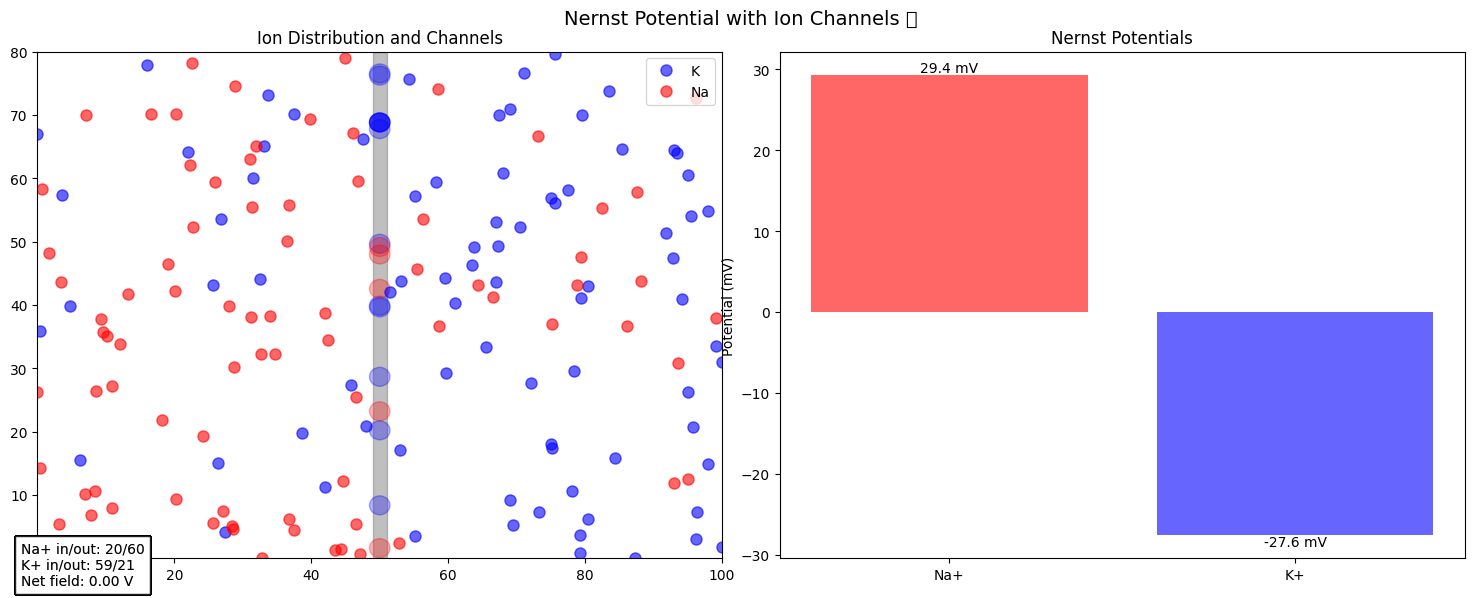

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle, Circle
import random

# Physical constants
R = 8.31446261815324    # Gas constant [J/(K⋅mol)]
T = 310.15              # Temperature [K] (37°C - physiological temperature)
z = 1                   # Ion valence
F = 96485.3321233100184 # Faraday constant [C/mol]

# Simulation space
WIDTH = 100
HEIGHT = 80

class IonChannel:
    def __init__(self, x, y, ion_type):
        self.x = x
        self.y = y
        self.ion_type = ion_type  # 'Na' or 'K'
        self.is_open = False
        self.open_probability = 0.1 if ion_type == 'K' else 0.05  # K+ channels more likely to open
        
    def update(self):
        # Random channel opening/closing
        self.is_open = random.random() < self.open_probability

class Ion:
    def __init__(self, x, y, ion_type):
        self.x = x
        self.y = y
        self.ion_type = ion_type
        self.vx = 0
        self.vy = 0
        
    def move(self, electric_field, channels):
        # Brownian motion
        self.vx = np.random.normal(0, 0.5)
        self.vy = np.random.normal(0, 0.5)
        
        # Effect of electric field (only in x direction across membrane)
        if self.ion_type == 'Na':
            self.vx += electric_field * 0.1  # Na+ affected by field
        else:
            self.vx -= electric_field * 0.1  # K+ affected oppositely
        
        # Update position
        new_x = self.x + self.vx
        new_y = self.y + self.vy
        
        # Check membrane collision (membrane at x = WIDTH/2)
        if 48 < new_x < 52:  # Membrane region
            can_pass = False
            for channel in channels:
                if (channel.ion_type == self.ion_type and 
                    channel.is_open and 
                    abs(channel.y - self.y) < 5):
                    can_pass = True
                    break
            
            if not can_pass:
                new_x = self.x  # Bounce back
                self.vx *= -0.5
        
        # Boundary conditions
        self.x = np.clip(new_x, 0, WIDTH)
        self.y = np.clip(new_y, 0, HEIGHT)

class NernstSimulation:
    def __init__(self):
        # Initialize ions with physiological distribution
        self.ions = []
        
        # More K+ inside (right side)
        for _ in range(60):  # High K+ concentration inside
            self.ions.append(Ion(random.uniform(52, WIDTH), 
                               random.uniform(0, HEIGHT), 'K'))
        
        for _ in range(20):  # Low K+ concentration outside
            self.ions.append(Ion(random.uniform(0, 48), 
                               random.uniform(0, HEIGHT), 'K'))
            
        # More Na+ outside (left side)
        for _ in range(60):  # High Na+ concentration outside
            self.ions.append(Ion(random.uniform(0, 48), 
                               random.uniform(0, HEIGHT), 'Na'))
            
        for _ in range(20):  # Low Na+ concentration inside
            self.ions.append(Ion(random.uniform(52, WIDTH), 
                               random.uniform(0, HEIGHT), 'Na'))
        
        # Create ion channels
        self.channels = []
        for _ in range(10):  # K+ channels
            self.channels.append(IonChannel(WIDTH/2, random.uniform(0, HEIGHT), 'K'))
        for _ in range(5):   # Na+ channels (fewer Na+ channels)
            self.channels.append(IonChannel(WIDTH/2, random.uniform(0, HEIGHT), 'Na'))
        
        # Setup figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(15, 6))
        self.fig.suptitle('Nernst Potential with Ion Channels 🧬', fontsize=14)
        
    def calculate_potential(self):
        # Count ions on each side
        na_in = sum(1 for ion in self.ions if ion.ion_type == 'Na' and ion.x > WIDTH/2)
        na_out = sum(1 for ion in self.ions if ion.ion_type == 'Na' and ion.x < WIDTH/2)
        k_in = sum(1 for ion in self.ions if ion.ion_type == 'K' and ion.x > WIDTH/2)
        k_out = sum(1 for ion in self.ions if ion.ion_type == 'K' and ion.x < WIDTH/2)
        
        # Calculate Nernst potential for each ion
        v_na = (R * T / (z * F)) * np.log(na_out/max(na_in, 1)) * 1000  # mV
        v_k = (R * T / (z * F)) * np.log(k_out/max(k_in, 1)) * 1000    # mV
        
        return v_na, v_k, na_in, na_out, k_in, k_out
    
    def update(self, frame):
        self.ax1.clear()
        self.ax2.clear()
        
        # Update ion channels
        for channel in self.channels:
            channel.update()
        
        # Calculate electric field based on current distribution
        v_na, v_k, na_in, na_out, k_in, k_out = self.calculate_potential()
        electric_field = (v_na + v_k) / 1000  # Convert back to V
        
        # Update ion positions
        for ion in self.ions:
            ion.move(electric_field, self.channels)
        
        # Draw membrane
        membrane = Rectangle((WIDTH/2-1, 0), 2, HEIGHT, color='gray', alpha=0.5)
        self.ax1.add_patch(membrane)
        
        # Draw ion channels
        for channel in self.channels:
            color = 'blue' if channel.ion_type == 'K' else 'red'
            alpha = 0.8 if channel.is_open else 0.3
            circle = Circle((channel.x, channel.y), 1.5, color=color, alpha=alpha)
            self.ax1.add_patch(circle)
        
        # Plot ions
        for ion in self.ions:
            color = 'red' if ion.ion_type == 'Na' else 'blue'
            self.ax1.plot(ion.x, ion.y, 'o', color=color, alpha=0.6, 
                         markersize=8, label=ion.ion_type)
        
        # Plot Nernst potentials
        bars = self.ax2.bar(['Na+', 'K+'], [v_na, v_k], 
                           color=['red', 'blue'], alpha=0.6)
        
        # Add value labels on bars
        for bar, v in zip(bars, [v_na, v_k]):
            height = bar.get_height()
            self.ax2.text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.1f} mV',
                         ha='center', va='bottom' if height > 0 else 'top')
        
        # Set plot properties
        self.ax1.set_xlim(0, WIDTH)
        self.ax1.set_ylim(0, HEIGHT)
        self.ax1.set_title('Ion Distribution and Channels')
        
        self.ax2.set_title('Nernst Potentials')
        self.ax2.set_ylabel('Potential (mV)')
        
        # Add concentration information
        plt.figtext(0.02, 0.02, 
                   f'Na+ in/out: {na_in}/{na_out}\n' +
                   f'K+ in/out: {k_in}/{k_out}\n' +
                   f'Net field: {electric_field:.2f} V', 
                   fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
        
        # Remove duplicate labels
        handles, labels = self.ax1.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        self.ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

    def save_animation(self):
        anim = FuncAnimation(self.fig, self.update, frames=200, interval=50)
        writer = PillowWriter(fps=20)
        plt.tight_layout()
        anim.save('nernst_physiological.gif', writer=writer)
        print("Animation saved as 'nernst_physiological.gif'")

# Run simulation
sim = NernstSimulation()
sim.save_animation() 